In [322]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')
import random as rnd
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
%matplotlib inline
SEED=4242
rnd.seed(10)
SIZE=30000
ALPHA=0.03
# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import collections
from sklearn.ensemble import RandomForestClassifier
# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score,\
 accuracy_score, classification_report, make_scorer, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.under_sampling import TomekLinks
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from xgboost import plot_importance
# Time Series Features
# import tsfresh as tsf
from datetime import date, timedelta
from scipy import signal
from scipy.stats import variation
# Imbalance handling
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, ClusterCentroids
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTETomek

In [323]:
df= pd.read_csv('/content/DFORE498.csv', low_memory=True)

In [324]:
print('Sample Size:', df.shape[0], 'Churn Cases:', sum(df.ChurnFlag))

Sample Size: 1143577 Churn Cases: 371365


In [325]:
df= df.loc[df.branch_name!= 'Buffalo']

In [326]:
df.loc[df.days_since_last_app_error==-999, 'no_of_app_error_ltd']=-999

In [327]:
df.loc[df.days_since_last_app_error==-999, 'no_of_app_error_ltd'].value_counts()

-999.0    276194
Name: no_of_app_error_ltd, dtype: int64

In [328]:
print('Sample Size:', df.shape[0], 'Churn Cases:', sum(df.ChurnFlag))

Sample Size: 1143291 Churn Cases: 371260


In [329]:
df.fillna(-999, inplace= True)

In [330]:
df.isnull().sum()

MnthYearCohort                   0
branch_name                      0
days_since_last_disconnect       0
no_of_disconnects_last_30days    0
days_since_last_vend             0
WalletBalance                    0
days_since_last_app_error        0
no_of_app_error_ltd              0
ChurnFlag                        0
dtype: int64

In [331]:
train= df.loc[df.MnthYearCohort.isin(['2022-01', '2022-02', '2022-03'])]
test= df.loc[df.MnthYearCohort.isin(['2022-04'])]

In [332]:
train.drop(['MnthYearCohort'], axis=1, inplace= True)
test.drop(['MnthYearCohort'], axis=1, inplace= True)

## Visuals

- Floor and Cap the variables to 10 and 90 percentiles
- split in q=4 and find proportions
- Split for change in entropy change?
- 

In [333]:
icols= ['days_since_last_disconnect',
       'no_of_disconnects_last_30days', 'days_since_last_vend',
       'WalletBalance', 'days_since_last_app_error', 'no_of_app_error_ltd']

In [334]:
def TreatOutliers(train, test, cols= icols, p=[.1,.9]):
  for c in icols:
    plower= train.loc[:,c].quantile(p[0])
    phigher= train.loc[:,c].quantile(p[1])
    train[c] = np.where(train[c] <plower, plower,train[c])
    train[c] = np.where(train[c] >phigher, phigher,train[c])
    test[c] = np.where(test[c] <plower, plower,test[c])
    test[c] = np.where(test[c] >phigher, phigher,test[c])
  return(train, test)

In [335]:
train, test= TreatOutliers(train, test)

In [336]:
train.describe(percentiles=[.1,.9])

,days_since_last_disconnect,no_of_disconnects_last_30days,days_since_last_vend,WalletBalance,days_since_last_app_error,no_of_app_error_ltd,ChurnFlag
count,384529.000000,384529.000000,384529.000000,384529.000000,384529.000000,384529.000000,384529.000000
mean,1.793789,23.538620,7.961316,5.016520,-269.959475,-280.076312,0.174928
std,2.699247,22.161749,6.923045,4.643337,462.140248,455.490539,0.379906
min,0.000000,4.000000,0.000000,0.500000,-999.000000,-999.000000,0.000000
10%,0.000000,4.000000,0.000000,0.500000,-999.000000,-999.000000,0.000000
50%,0.000000,14.000000,6.000000,3.500000,8.000000,2.000000,0.000000
90%,8.000000,73.000000,21.000000,15.000000,57.000000,23.000000,1.000000
max,8.000000,73.000000,21.000000,15.000000,57.000000,23.000000,1.000000


In [337]:
def Conti2Bkt(df, qrt=5):
  labls= ['Bkt'+str(x) for x in list(range(1,qrt+1))]
  numCols=[]
  SeriesLst=[]
  numCols= df.select_dtypes(include=np.number).columns.tolist()
  for c in numCols:
    if c != 'ChurnFlag':
      bkt= pd.qcut(df[c], q= qrt,duplicates= 'drop')
      SeriesLst.append(bkt)
  df_bkt= pd.concat(SeriesLst, axis=1)
  df_bkt['Branch']= df.branch_name
  df_bkt['ChurnFlag']= df.ChurnFlag
  return(df_bkt)

In [338]:
df_bkt= Conti2Bkt(train)

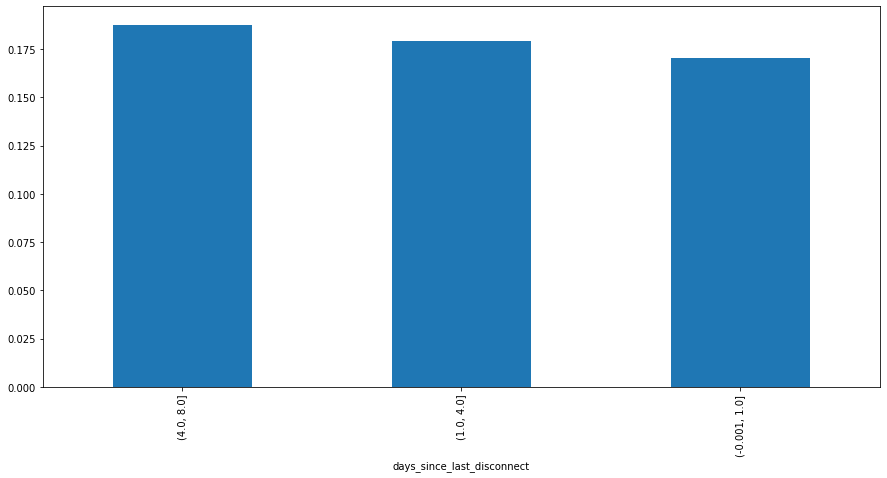

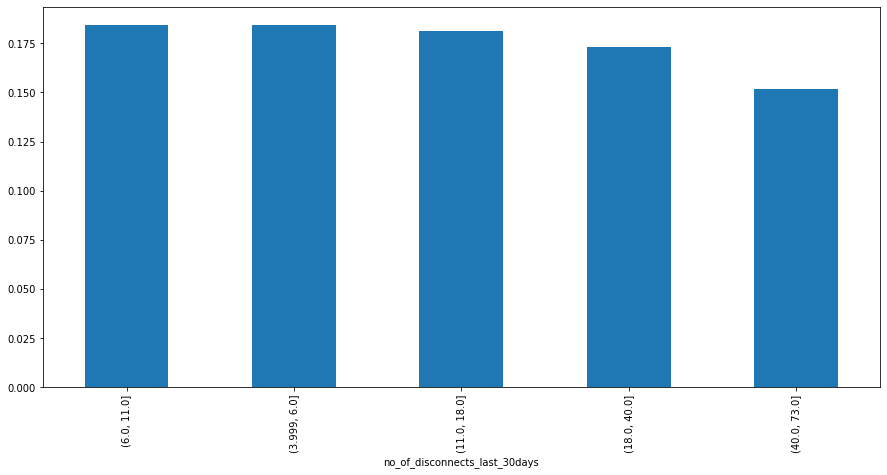

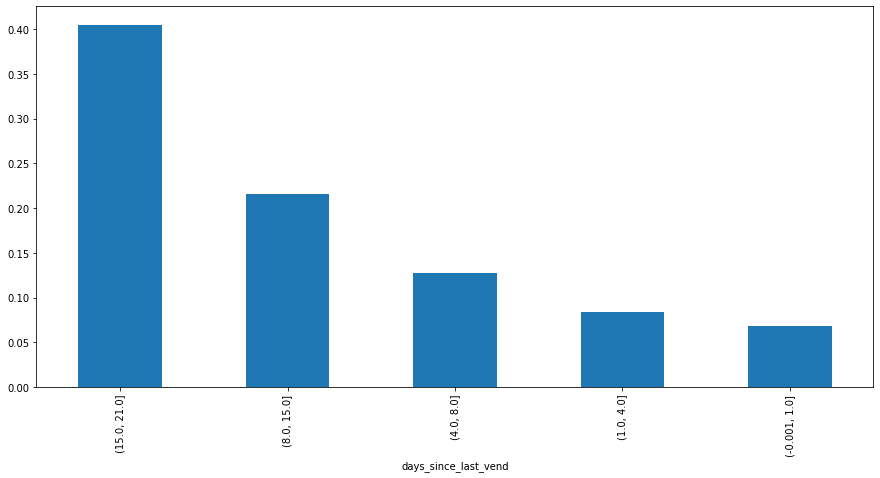

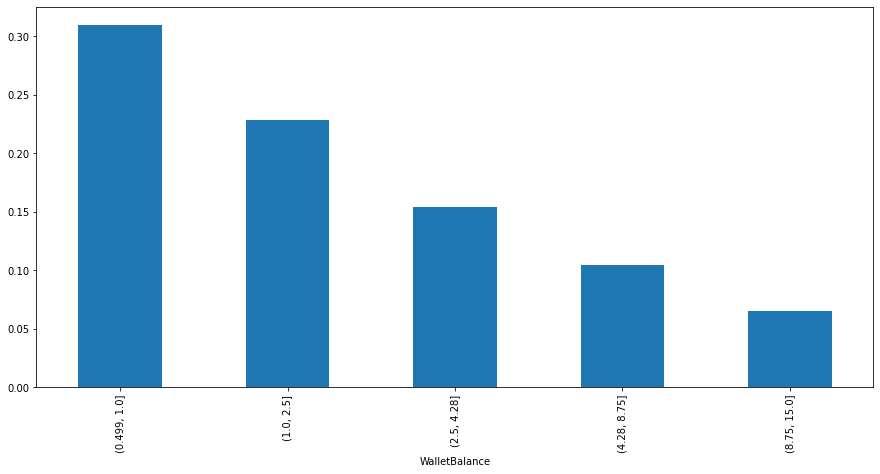

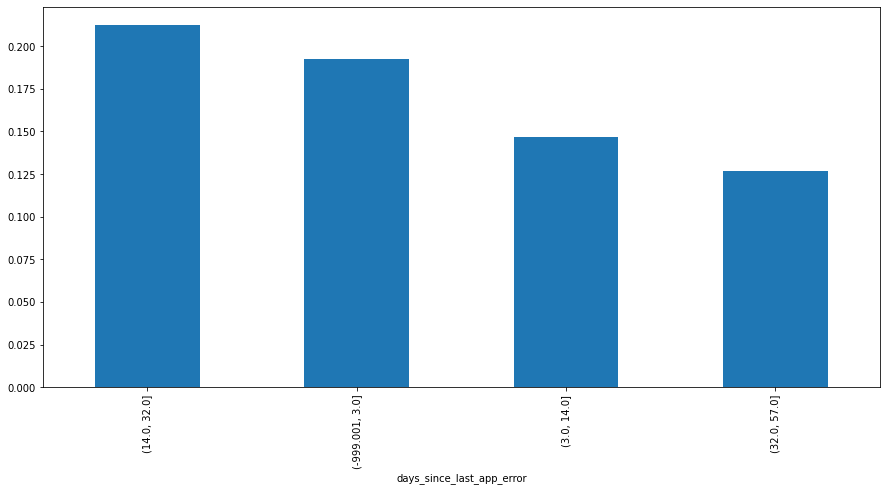

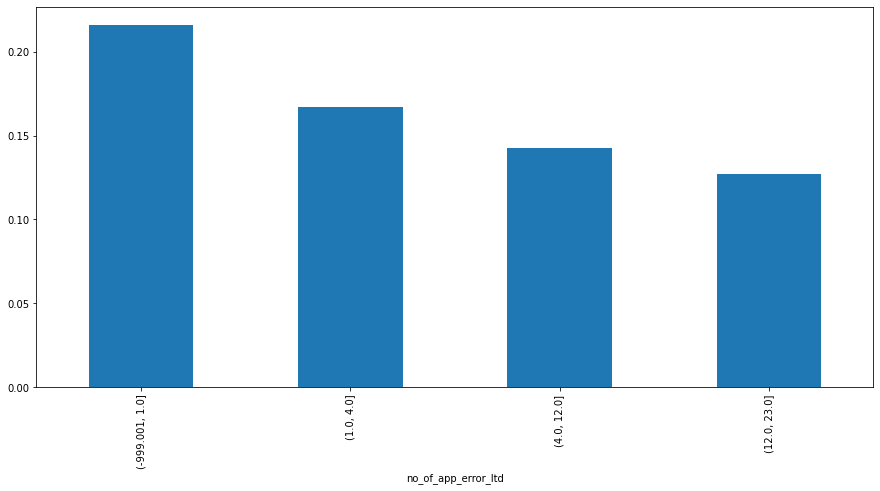

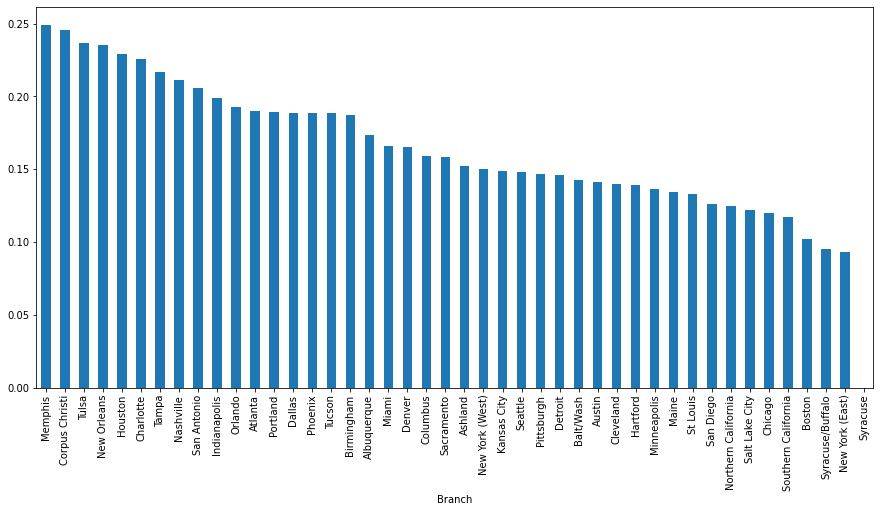

In [339]:
for c in df_bkt.columns.tolist():
  if c != 'ChurnFlag':
    plt.figure(figsize=(15,7))
    df_bkt.groupby(c)['ChurnFlag'].mean().sort_values(ascending= False).plot.bar()
    plt.show()

In [340]:
train.columns

Index(['branch_name', 'days_since_last_disconnect',
       'no_of_disconnects_last_30days', 'days_since_last_vend',
       'WalletBalance', 'days_since_last_app_error', 'no_of_app_error_ltd',
       'ChurnFlag'],
      dtype='object')

# Predictions

In [341]:
print(len(pd.get_dummies(train.branch_name, 'Branch').columns))
print(len(pd.get_dummies(test.branch_name, 'Branch').columns))

44
44


In [342]:
set(pd.get_dummies(test.branch_name, 'Branch').columns)- set(pd.get_dummies(train.branch_name, 'Branch').columns)

set()

In [343]:
train = pd.get_dummies(train, prefix='Branch', prefix_sep='_', columns=['branch_name'])
test = pd.get_dummies(test, prefix='Branch', prefix_sep='_', columns=['branch_name'])

In [344]:
print( 'train', train.shape[0], sum(train.ChurnFlag), 100.00*sum(train.ChurnFlag)/train.shape[0])
print('test', test.shape[0], sum(test.ChurnFlag), 100.00*sum(test.ChurnFlag)/test.shape[0])

train 384529 67265 17.492828889368553
test 166635 30183 18.113241515888017


In [345]:
print(train.select_dtypes(exclude=np.number).columns)
print(test.select_dtypes(exclude=np.number).columns)

Index([], dtype='object')
Index([], dtype='object')


In [352]:
cols=['days_since_last_disconnect', 'no_of_disconnects_last_30days',
       'days_since_last_vend', 'WalletBalance', 'days_since_last_app_error',
       'no_of_app_error_ltd', 'Branch_Albuquerque',
       'Branch_Ashland', 'Branch_Atlanta', 'Branch_Austin', 'Branch_Balt/Wash',
       'Branch_Birmingham', 'Branch_Boston', 'Branch_Charlotte',
       'Branch_Chicago', 'Branch_Cleveland', 'Branch_Columbus',
       'Branch_Corpus Christi', 'Branch_Dallas', 'Branch_Denver',
       'Branch_Detroit', 'Branch_Hartford', 'Branch_Houston',
       'Branch_Indianapolis', 'Branch_Kansas City', 'Branch_Maine',
       'Branch_Memphis', 'Branch_Miami', 'Branch_Minneapolis',
       'Branch_Nashville', 'Branch_New Orleans', 'Branch_New York (East)',
       'Branch_New York (West)', 'Branch_Northern California',
       'Branch_Orlando', 'Branch_Phoenix', 'Branch_Pittsburgh',
       'Branch_Portland', 'Branch_Sacramento', 'Branch_Salt Lake City',
       'Branch_San Antonio', 'Branch_San Diego', 'Branch_Seattle',
       'Branch_Southern California', 'Branch_St Louis', 'Branch_Syracuse',
       'Branch_Syracuse/Buffalo', 'Branch_Tampa', 'Branch_Tucson',
       'Branch_Tulsa']

In [353]:
y_train= train.ChurnFlag
y_test= test.ChurnFlag
X_train=train[cols]
X_test= test[cols]

In [354]:
MinMax= MinMaxScaler()
X_train2= MinMax.fit_transform(X_train)
X_test2= MinMax.transform(X_test)

In [355]:
print(np.sum(np.isnan(X_train2)))
print(np.sum(np.isnan(X_test2)))

0
0


In [350]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

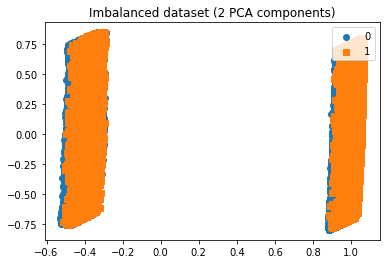

In [357]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = pca.fit_transform(X_train2)

plot_2d_space(X, y_train, 'Imbalanced dataset (2 PCA components)')

In [365]:
from pandas.core.common import random_state
classifiers = {
    "LogisiticRegression": LogisticRegression(class_weight='balanced', random_state=SEED),
    "DecisionTreeClassifier": DecisionTreeClassifier(class_weight='balanced', random_state=SEED),
    "RandomForest": RandomForestClassifier(class_weight= 'balanced', random_state=SEED),
    "XGBClassifier": xgb.XGBRFClassifier(tree_method="hist", random_state=SEED)
}
scorer={'f1_scorer': make_scorer(f1_score),
        'auc_scorer': make_scorer(roc_auc_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score)}

In [366]:
recs=[]
for key, classifier in classifiers.items():
  rec=[]
  print(key)
  classifier.fit(X_train2, y_train)
  training_score = cross_validate(classifier,X_train2, y_train, cv=5, scoring= scorer)
  y_hat= classifier.predict(X_test2)
  rec=[key]
  rec.extend(list(np.array(list(training_score.values())).mean(axis=1)[2:]))
    # roc_auc_score(v[3], classifier.predict_proba(v[2])[:, 1])
  rec.extend([f1_score(y_test, y_hat),roc_auc_score(y_test, classifier.predict_proba(X_test2)[:, 1]), precision_score(y_test, y_hat), recall_score(y_hat, y_test)])
  recs.append(rec)

LogisiticRegression
DecisionTreeClassifier
RandomForest
XGBClassifier
